In [ ]:

import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!cp /content/drive/MyDrive/arch.zip  /content/data

In [ ]:
!jar xvf data/arch.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1270.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg
 inflated: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1282.jpg
 inflated: simpsons_dat

In [ ]:
data_image_paths

NameError: ignored

In [ ]:

# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)


Изображений в train: 14653
Изображений в val: 6280


In [ ]:
from torchvision.datasets.folder import default_loader
def is_valid_file(filepath,paths):
  if filepath in paths:
    print(filepath)
    if  not filepath.endswith('.jpg') and not filepath.endswith('.jpeg') and not filepath.endswith('.png') :
          return False
    try:
        default_loader(filepath)
        print(filepath)
        return True
    except:
        return False
  else:
    return False

In [ ]:

input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])



train_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)
val_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:

print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))


Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))


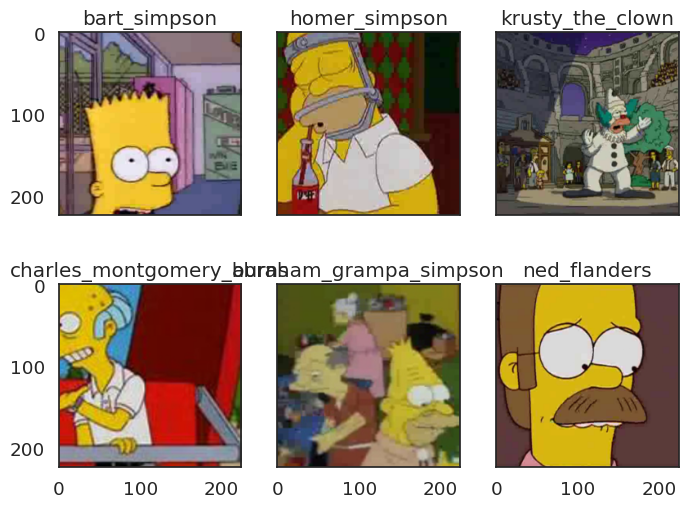

In [ ]:
show_images(val_dataset)

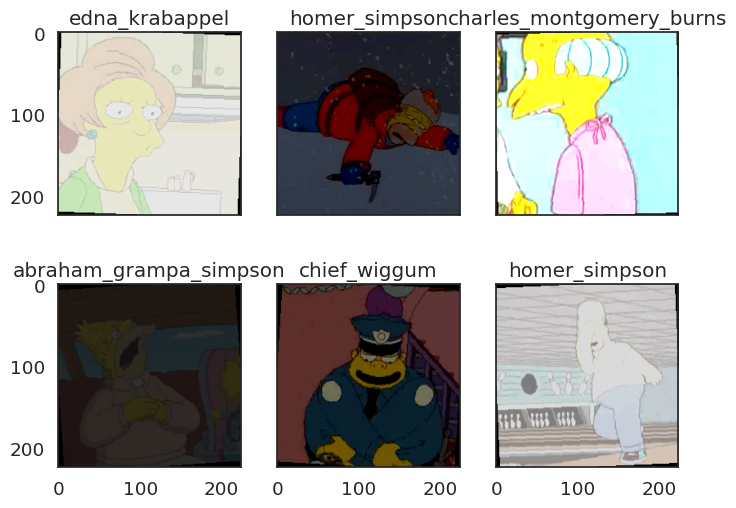

In [ ]:
show_images(train_dataset)

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:

def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:

batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:

from torchvision.models import mobilenet_v2


In [ ]:
def train(
    model,
    criterion,
    optimizer,
     scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        print(f'Epoch = {epoch}')
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    plot_learning_curves(history)

    return model, history



Epoch 10 of 10 took 172.113s
  training loss (in-iteration): 	875.092814
  validation loss (in-iteration): 	1327.974728
  training accuracy: 			45.05 %
  validation accuracy: 			52.07 %


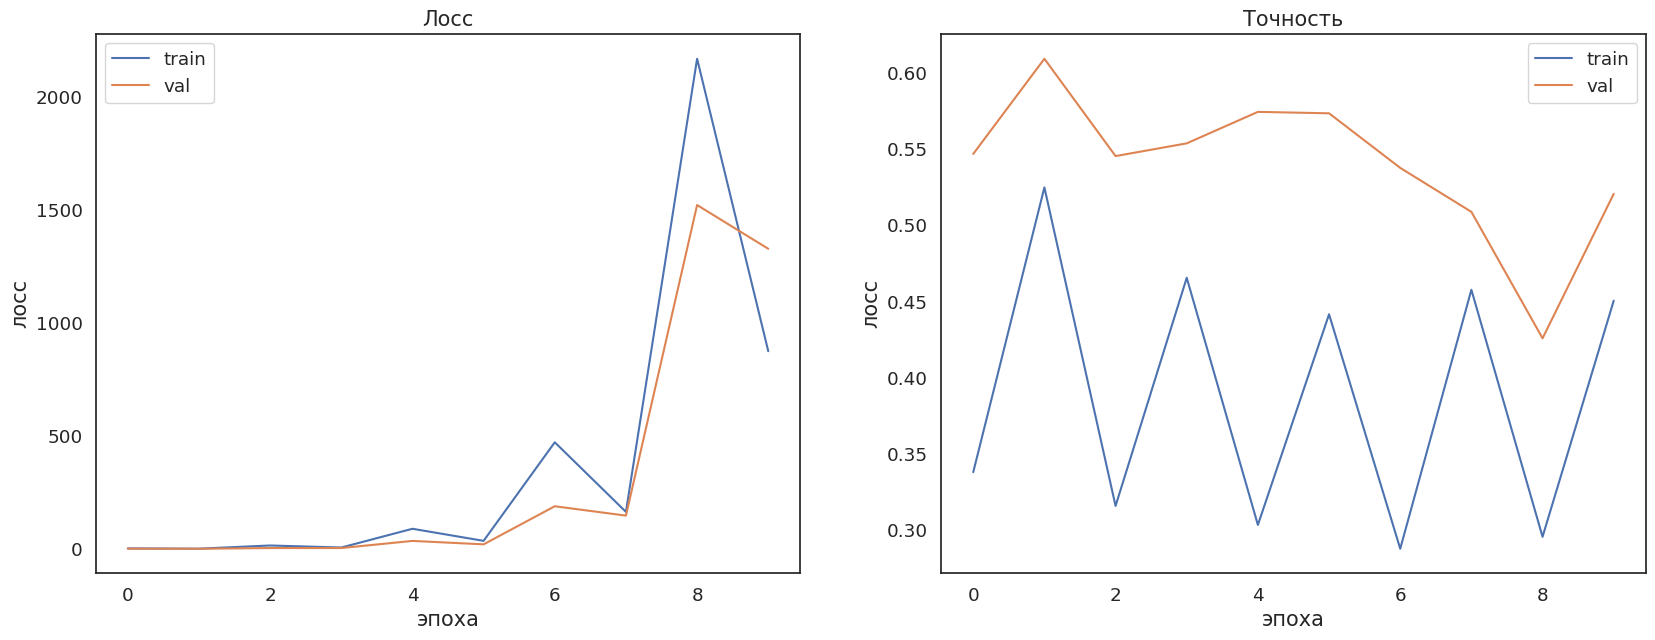

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models import vgg16
model = mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


model.classifier = nn.Linear(1280, 43)
model = model.to(device)
print("Params to learn:")
params_to_update = []

for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(f'name = {name}')
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2,gamma=5)
clf_model, history = train(
    model, criterion, optimizer,scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Здесь можно увидеть, что при большом значении гамма learning rate увеличивается, и не удается уменьшить то, что мешает найти минимум.

Epoch 10 of 10 took 179.120s
  training loss (in-iteration): 	28.479354
  validation loss (in-iteration): 	22.180270
  training accuracy: 			50.25 %
  validation accuracy: 			57.65 %


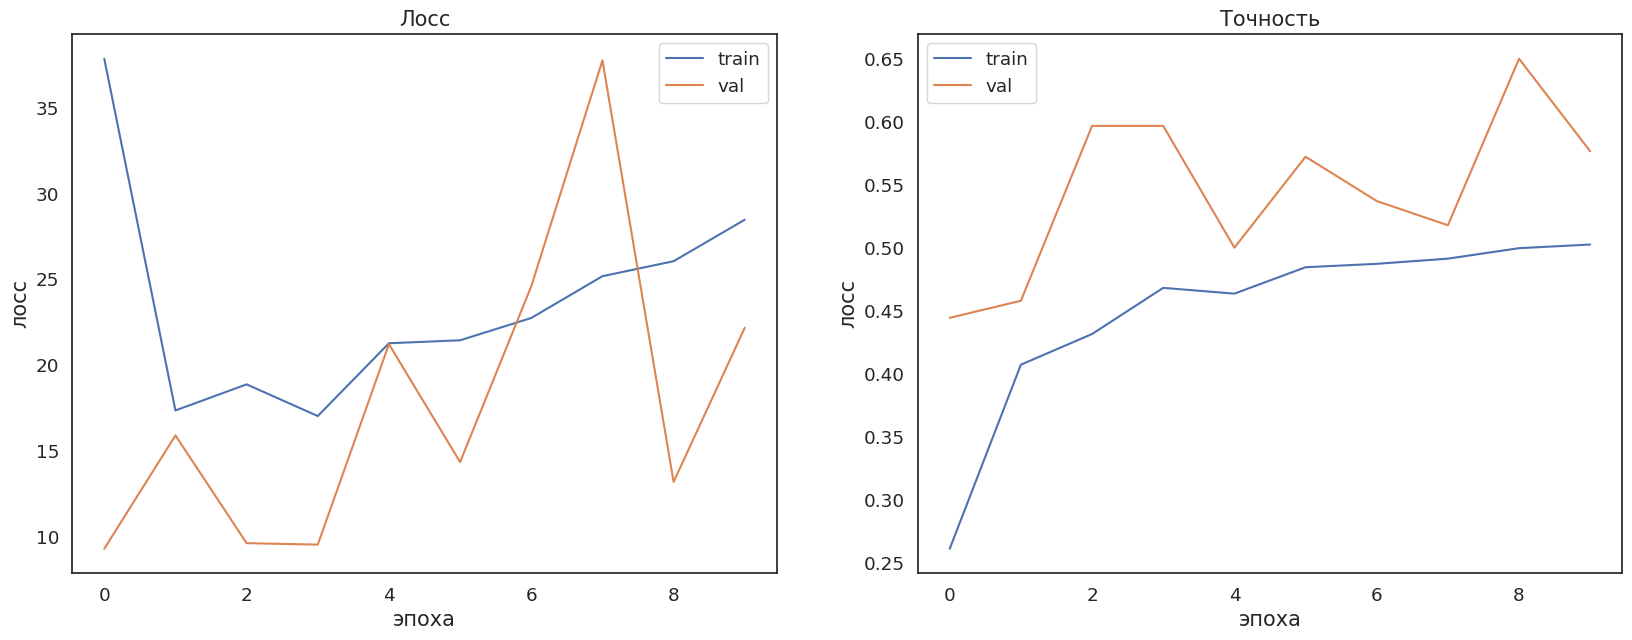

In [ ]:

from torchvision.models import vgg16
model = mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


model.classifier = nn.Linear(1280, 43)
model = model.to(device)
print("Params to learn:")
params_to_update = []

for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(f'name = {name}')
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, step_size_up = 5000,base_lr=0.8,max_lr=1000,gamma=5,cycle_momentum=False)
clf_model, history = train(
    model, criterion, optimizer,scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Здесь аналогично, но также есть очень большое значение step_size up, что также мешает уменьшению learning rate.